# Calculation of alternate climate divisions from nClimGrid data using hierarchical clustering, specifically Ward's method

### imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from metpy.plots import USCOUNTIES
from matplotlib.offsetbox import AnchoredText

import pickle

from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import os


### read in the nClimGrid data, subset down in space and time to Colorado and the period of interest
#### nClimGrid originally downloaded from: https://www.ncei.noaa.gov/thredds/catalog/data-in-development/nclimgrid/catalog.html

In [2]:
lonmin=-109.096667
lonmax=-102.0
latmin=36.95
latmax=41.05

### note -- nClimGrid can change after the fact! 
### use these provided files for reproducible results, otherwise the results may not be exactly the same
### these are based on the nClimGrid files released in April 2022.
tavg = xr.open_dataset("nclimgrid_tavg_CO_forclusters.nc").sel(lon=slice(lonmin,lonmax), lat=slice(latmax,latmin))
prcp = xr.open_dataset("nclimgrid_prcp_CO_forclusters.nc").sel(lon=slice(lonmin,lonmax), lat=slice(latmax,latmin))

tavg = tavg.sel(time=slice('1950-1-1','2021-12-31'))
prcp = prcp.sel(time=slice('1950-1-1','2021-12-31'))

### calculate climatology over the 1950-1999 period

In [3]:
tavg_monmean = tavg.sel(time=slice('1950-1-1','1999-12-31')).groupby("time.month").mean("time")
prcp_monmean = prcp.sel(time=slice('1950-1-1','1999-12-31')).groupby("time.month").mean("time")

### and the monthly anomalies

In [4]:
tavg_anom = tavg.groupby("time.month") - tavg_monmean
prcp_anom = prcp.groupby("time.month") - prcp_monmean

### inspect the dataset 

In [5]:
prcp_anom


<xarray.Dataset>
Dimensions:  (time: 864, lat: 98, lon: 170)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float32 41.02 40.98 40.94 40.9 ... 37.1 37.06 37.02 36.98
  * lon      (lon) float32 -109.1 -109.0 -109.0 -108.9 ... -102.1 -102.1 -102.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prcp     (lat, lon, time) float32 8.678 9.086 -2.089 ... -16.54 -9.079

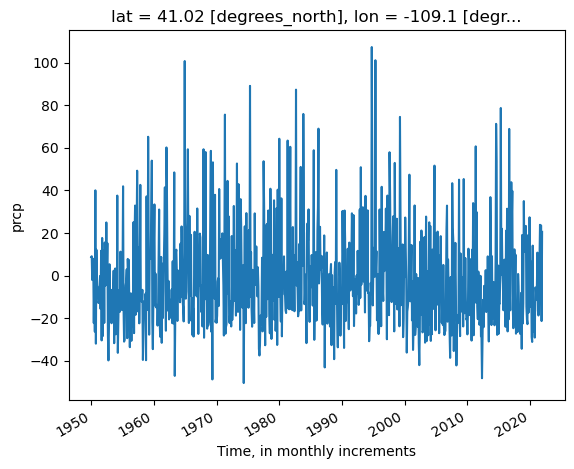

In [6]:
prcp_anom.prcp[0,0].plot()


### now reshape these into numpy arrays that are x*y, t

In [7]:
var1 = prcp_anom.prcp
prcp_anom_reshape = var1.to_numpy().reshape(var1.shape[0]*var1.shape[1],var1.shape[2])

var2 = tavg_anom.tavg
tavg_anom_reshape = var2.to_numpy().reshape(var2.shape[0]*var2.shape[1],var2.shape[2])

prcp_anom_reshape.shape

(16660, 864)

Now follow the steps here, using our data: https://towardsdatascience.com/how-to-apply-hierarchical-clustering-to-time-series-a5fe2a7d8447
------

### reshape the data and put into a pandas dataframe. Result is a pandas dataframe with the time series for each gridpoint in a column

In [8]:
tsers_tavg = pd.DataFrame(tavg_anom_reshape.transpose())
tsers_prcp = pd.DataFrame(prcp_anom_reshape.transpose())

tsers_tavg

,0,1,2,3,4,5,6,7,8,9,...,16650,16651,16652,16653,16654,16655,16656,16657,16658,16659
0,-3.371211,-3.331758,-3.300664,-3.243301,-3.182266,-3.109746,-3.014356,-2.895098,-2.755176,-2.583906,...,0.670117,0.689668,0.689746,0.733242,0.775664,0.833594,0.899570,0.967773,1.032559,1.115098
1,-2.643750,-2.599785,-2.553594,-2.504082,-2.440820,-2.358769,-2.274375,-2.149277,-2.012988,-1.844121,...,2.839805,2.850156,2.851856,2.854785,2.868027,2.885176,2.889922,2.896992,2.915957,2.917305
2,-1.323398,-1.333066,-1.332441,-1.343457,-1.334297,-1.320234,-1.312910,-1.275254,-1.236953,-1.180605,...,-0.243047,-0.241738,-0.239785,-0.239395,-0.245390,-0.249336,-0.254414,-0.267735,-0.268125,-0.278301
3,-0.234023,-0.255801,-0.277734,-0.296992,-0.319277,-0.328652,-0.346621,-0.347285,-0.346015,-0.333555,...,0.499804,0.482325,0.454590,0.444629,0.436309,0.440215,0.440801,0.439981,0.439883,0.451211
4,-2.613906,-2.625215,-2.626406,-2.638614,-2.642852,-2.649140,-2.654707,-2.660898,-2.669434,-2.680176,...,0.412500,0.411211,0.398359,0.395840,0.402306,0.400078,0.404200,0.408575,0.411427,0.439903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,0.564648,0.585996,0.607246,0.655293,0.673456,0.688515,0.699726,0.698692,0.698027,0.694355,...,0.449160,0.489552,0.518867,0.535761,0.564259,0.590157,0.606426,0.620743,0.632656,0.646757
860,1.747070,1.769941,1.774239,1.787637,1.787207,1.816015,1.834199,1.847832,1.871407,1.904433,...,2.177383,2.215078,2.240450,2.264179,2.288067,2.308046,2.326288,2.325390,2.331133,2.336798
861,-0.132168,-0.113633,-0.096445,-0.068301,-0.052344,-0.024160,-0.000215,0.028887,0.059414,0.081387,...,0.691875,0.741777,0.802071,0.862247,0.911563,0.953632,1.002460,1.041523,1.094063,1.138437
862,3.976621,3.994512,3.993516,4.024805,4.054062,4.079766,4.106582,4.140390,4.175820,4.209434,...,2.648164,2.671640,2.703184,2.726309,2.761562,2.787129,2.809512,2.826621,2.851855,2.876348


### calculate the correlation matrix of both variables

In [9]:
%%time

corr_matrix_tavg = tsers_tavg.corr()
corr_matrix_prcp = tsers_prcp.corr()
corr_matrix_tavg

CPU times: user 9min 34s, sys: 4 s, total: 9min 38s
Wall time: 9min 40s


,0,1,2,3,4,5,6,7,8,9,...,16650,16651,16652,16653,16654,16655,16656,16657,16658,16659
0,1.000000,0.999891,0.999584,0.999044,0.998483,0.997630,0.996823,0.995950,0.994878,0.993423,...,0.615758,0.613609,0.611559,0.609202,0.606739,0.604186,0.601344,0.598325,0.595584,0.591566
1,0.999891,1.000000,0.999884,0.999537,0.999135,0.998465,0.997790,0.997029,0.996062,0.994721,...,0.616916,0.614767,0.612733,0.610387,0.607941,0.605408,0.602587,0.599580,0.596858,0.592851
2,0.999584,0.999884,1.000000,0.999845,0.999593,0.999093,0.998540,0.997888,0.997023,0.995777,...,0.618174,0.616023,0.614003,0.611663,0.609227,0.606708,0.603896,0.600889,0.598172,0.594160
3,0.999044,0.999537,0.999845,1.000000,0.999910,0.999589,0.999177,0.998651,0.997903,0.996776,...,0.619270,0.617125,0.615119,0.612788,0.610368,0.607869,0.605072,0.602076,0.599376,0.595373
4,0.998483,0.999135,0.999593,0.999910,1.000000,0.999846,0.999569,0.999173,0.998556,0.997573,...,0.620533,0.618405,0.616427,0.614116,0.611721,0.609251,0.606482,0.603503,0.600828,0.596847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16655,0.604186,0.605408,0.606708,0.607869,0.609251,0.610158,0.611733,0.613683,0.615918,0.618871,...,0.997085,0.998189,0.998942,0.999500,0.999855,1.000000,0.999829,0.999442,0.998633,0.997377
16656,0.601344,0.602587,0.603896,0.605072,0.606482,0.607400,0.608989,0.610960,0.613226,0.616208,...,0.995741,0.997070,0.998036,0.998821,0.999423,0.999829,1.000000,0.999867,0.999360,0.998446
16657,0.598325,0.599580,0.600889,0.602076,0.603503,0.604431,0.606025,0.608011,0.610298,0.613303,...,0.994290,0.995823,0.996979,0.997973,0.998796,0.999442,0.999867,1.000000,0.999776,0.999168
16658,0.595584,0.596858,0.598172,0.599376,0.600828,0.601770,0.603377,0.605378,0.607688,0.610712,...,0.992257,0.994028,0.995397,0.996627,0.997707,0.998633,0.999360,0.999776,1.000000,0.999755


### pickle these for potential time savings later

In [10]:
###now pickle them
pickle.dump( corr_matrix_tavg, open( "corr_matrix_tavg_post1950_pub.pkl", "wb" ) )
pickle.dump( corr_matrix_prcp, open( "corr_matrix_prcp_post1950_pub.pkl", "wb" ) )

### or read pickles in

#with open("corr_matrix_tavg_post1950_pub.pkl", 'rb') as pickle_file:
#    corr_matrix_tavg = pickle.load(pickle_file)
    
#with open("corr_matrix_tavg_post1950_pub.pkl", 'rb') as pickle_file:
#    corr_matrix_prcp = pickle.load(pickle_file)    


### convert correlation into a squared euclidean distance, based on discussion in this post: https://stats.stackexchange.com/questions/165194/using-correlation-as-distance-metric-for-hierarchical-clustering


In [11]:
distance_matrix_tavg = 2*(1 - corr_matrix_tavg)
distance_matrix_prcp = 2*(1 - corr_matrix_prcp)


### now sum the distance matrices of the two variables to get a 'total distance' based on both temperature and precip anomalies

In [12]:
distance_matrix = distance_matrix_tavg + distance_matrix_prcp
distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,16650,16651,16652,16653,16654,16655,16656,16657,16658,16659
0,0.000000,0.003715,0.009233,0.021233,0.033400,0.048470,0.066503,0.085971,0.106571,0.137126,...,2.520336,2.525171,2.537289,2.540605,2.547954,2.557671,2.565708,2.576387,2.586220,2.592085
1,0.003715,0.000000,0.004176,0.016305,0.025952,0.041092,0.060209,0.079728,0.098952,0.129654,...,2.520435,2.525294,2.537065,2.540126,2.547341,2.557148,2.564983,2.575355,2.584960,2.590648
2,0.009233,0.004176,0.000000,0.007137,0.013174,0.024614,0.040508,0.057219,0.074288,0.102207,...,2.523637,2.528485,2.540303,2.543029,2.550030,2.559602,2.567279,2.577482,2.586835,2.592049
3,0.021233,0.016305,0.007137,0.000000,0.002257,0.007496,0.017072,0.028680,0.042518,0.066026,...,2.511314,2.516383,2.528644,2.531397,2.538591,2.548854,2.556803,2.567315,2.576897,2.581881
4,0.033400,0.025952,0.013174,0.002257,0.000000,0.002935,0.009856,0.019104,0.030773,0.051903,...,2.511840,2.516809,2.528878,2.531381,2.538378,2.548594,2.556320,2.566689,2.576101,2.580933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16655,2.557671,2.557148,2.559602,2.548854,2.548594,2.546724,2.538770,2.533384,2.534335,2.537401,...,0.084221,0.059879,0.035516,0.016506,0.006371,0.000000,0.003159,0.016052,0.032239,0.057015
16656,2.565708,2.564983,2.567279,2.556803,2.556320,2.554632,2.546583,2.541178,2.542056,2.545301,...,0.116064,0.087378,0.057650,0.032093,0.016858,0.003159,0.000000,0.005819,0.016700,0.036014
16657,2.576387,2.575355,2.577482,2.567315,2.566689,2.565177,2.557394,2.551976,2.552847,2.556297,...,0.166021,0.131833,0.094821,0.060708,0.038613,0.016052,0.005819,0.000000,0.003486,0.015160
16658,2.586220,2.584960,2.586835,2.576897,2.576101,2.574746,2.567099,2.561849,2.562788,2.566541,...,0.207758,0.169613,0.127816,0.087741,0.061063,0.032239,0.016700,0.003486,0.000000,0.004840


### condense the distance matrix

In [13]:
condensed_dist_matrix = squareform(distance_matrix)
condensed_dist_matrix.shape

(138769470,)

### calculate the linkage matrix with ward's method

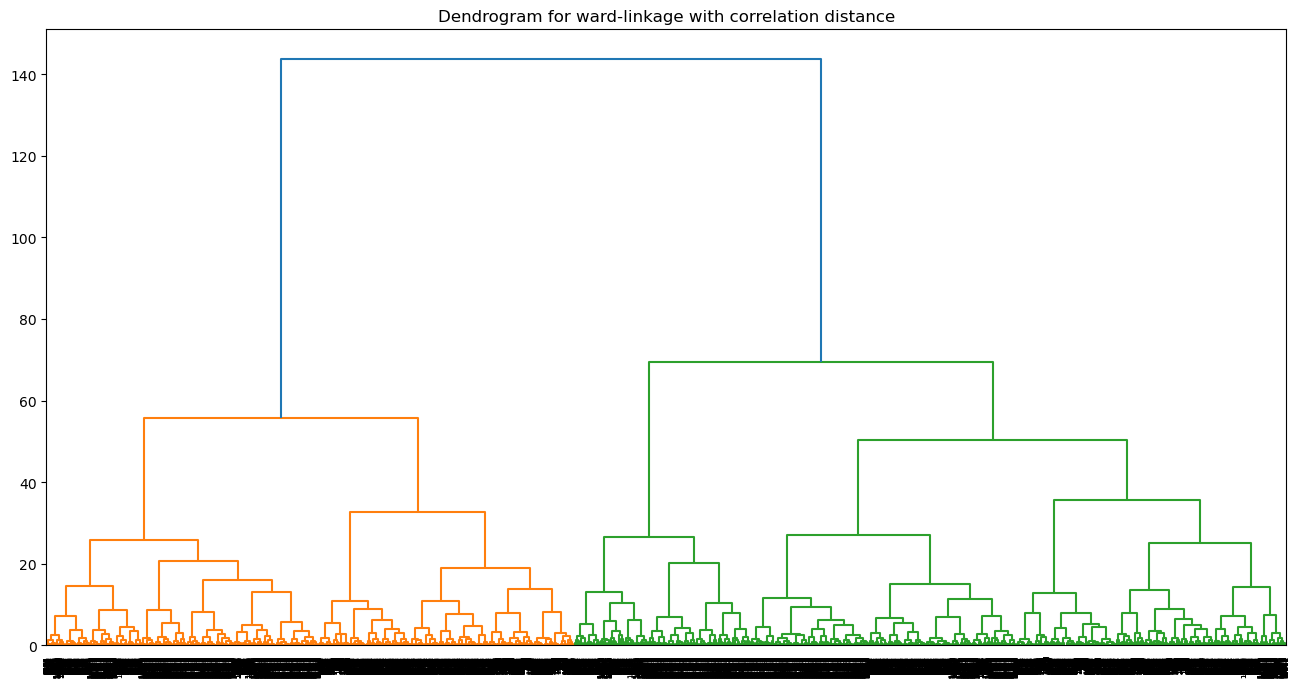

CPU times: user 1min 1s, sys: 7.32 s, total: 1min 8s
Wall time: 1min 9s


In [14]:
%%time

def hierarchical_clustering(dist_mat, method='ward'):
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

#linkage_matrix = hierarchical_clustering(distance_matrix)
linkage_matrix = hierarchical_clustering(condensed_dist_matrix)

### pickle the linkage matrix

In [15]:
pickle.dump( linkage_matrix, open( "linkage_matrix_tavg_prcp_sum_post1950_pub.pkl", "wb" ) )

#with open("linkage_matrix_tavg_prcp_sum_post1950_pub.pkl", 'rb') as pickle_file:
#    linkage_matrix = pickle.load(pickle_file)


### plot pdf version of dendrogram

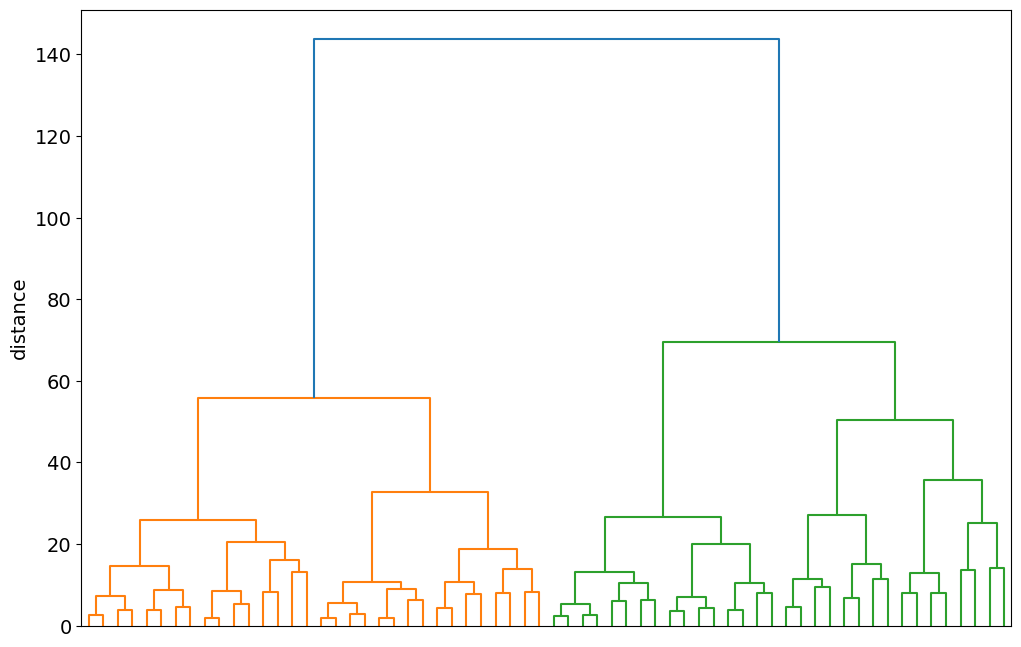

In [16]:
fig = plt.figure(figsize=(12, 8))

#dn = dendrogram(linkage_matrix)
dn = dendrogram(linkage_matrix, 5, truncate_mode='level')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(axis='y', labelsize=14)
plt.ylabel('distance', fontsize=14)
plt.show()

fig.savefig('dendrogram.pdf', bbox_inches='tight', transparent=False, facecolor='white', dpi=250)

plt.close('all')


### now establish the actual clusters, either with a number of clusters, or by using a cutoff on the linkage matrix

In [17]:
# select maximum number of clusters
nclusters=11
cluster_labels = fcluster(linkage_matrix, nclusters, criterion='maxclust')

### or use a cutoff value
### for example, a cutoff value of 27.5 (this could be visualized from the dendrogram)
#cluster_labels = fcluster(linkage_matrix, 27.5, criterion='distance')

print(np.unique(cluster_labels))
nclusters = len(np.unique(cluster_labels))

[ 1  2  3  4  5  6  7  8  9 10 11]


### now reshape the cluster labels back to the original shape - assigning grid points to each cluster

In [18]:
clusters = cluster_labels.reshape(prcp_anom.prcp.shape[0],prcp_anom.prcp.shape[1])

### and write those back into a variable in the original xr dataset

In [19]:
prcp_anom["clusters_tavg_prcp_sum"]=(['lat', 'lon'],  clusters)

### make a map of the clusters

/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


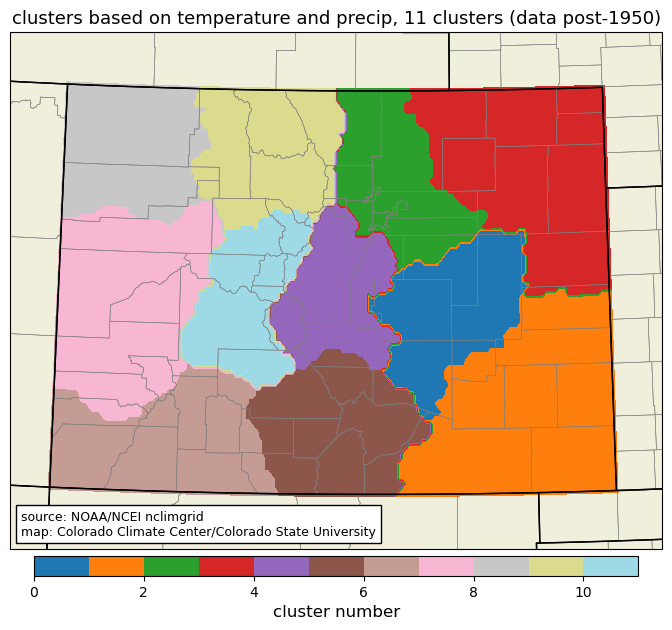

In [20]:
crs = ccrs.LambertConformal(central_longitude=-105.0, central_latitude=37.5)
#crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=42.0)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=crs)

## Colorado versions
lonmin=-109.5
lonmax=-101.5
latmin=36.4
latmax=41.5
#lonmin=-109.046667
#lonmax=-102.046667
#latmin=37.0
#latmax=41.0

#ax.set_extent([235., 290., 20., 55.])
#ax.set_extent((-109.5,-101.5,36.4,41.5))
ax.set_extent([lonmin,lonmax,latmin,latmax])
ax.add_feature(cfeature.LAND)
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.4)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

## t rank
cf1 = ax.contourf(prcp_anom.lon, prcp_anom.lat, prcp_anom.clusters_tavg_prcp_sum, 
                         np.arange(0,nclusters+1), 
                  cmap=plt.get_cmap('tab20'),
                  transform=ccrs.PlateCarree())

ax.set_title("clusters based on temperature and precip, "+str(nclusters)+" clusters (data post-1950)", fontsize=13)
cb1 = fig.colorbar(cf1, ax=ax, orientation='horizontal', aspect=30, shrink=0.65, pad=0.01)
cb1.set_label('cluster number', size='large')

# Add a text annotation 
text = AnchoredText("source: NOAA/NCEI nclimgrid\nmap: Colorado Climate Center/Colorado State University",
                    loc='lower left', prop={'size': 9}, frameon=True)
ax.add_artist(text)

fig.savefig("clusters_tavg_prcp_"+str(nclusters).zfill(2)+"clusters_post1950_pub.pdf",
           dpi=225,transparent=False, facecolor='white', bbox_inches='tight')

plt.show()

plt.close('all')



### if desired, write the calculated clusters out to a netcdf file

In [21]:
prcp_anom.clusters_tavg_prcp_sum.to_netcdf("clusters_tavg_prcp_sum_post1950_"+str(nclusters)+"_pub.nc")